In [403]:

import statsmodels.api as sm
from sklearn.model_selection import test_split
import math
import random
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import datetime
import scipy.stats as stats
from scipy.stats import genextreme
from scipy.stats import percentileofscore
import yfinance as yf
import requests
from bs4 import BeautifulSoup
from itertools import product
import matplotlib.pyplot as plt

from pyextremes import get_extremes
from pyextremes.plotting import plot_extremes



In [478]:
tickers = input("Enter a list of tickers separated by space ")
tickers  = tickers.split()

startDate = input('Enter Start Date in DD-MM-YYYY format')
year, month, day = map(int, startDate.split('-'))
startDate = datetime.date(day,month,year)

endDate = input('Enter End Date in DD-MM-YYYY format')
year, month, day = map(int, endDate.split('-'))
endDate = datetime.date(day,month,year)

confidence_level = float(input('Enter Confidence level in float format'))

print(f'Tickers: {tickers}')
print(f'Start Date: {startDate}')
print(f'End Date: {endDate}')
print(f'Confidence Level: {str(confidence_level)}')

Tickers: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'FB', 'TSLA', 'NVDA', 'NFLX', 'INTC', 'CSCO', 'IBM', 'ORCL', 'QCOM', 'ADBE']
Start Date: 2018-01-01
End Date: 2024-01-01
Confidence Level: 0.99


# 1. Collect Price Data

In [479]:
# Fetch data using yfinance
yf_data = yf.download(tickers, start=startDate, end=endDate)

# Convert the data to a DataFrame
stockdata = pd.DataFrame(yf_data)[['Adj Close']]

stockdata.columns = stockdata.columns.droplevel(0)
stockdata = stockdata.pct_change()
# Drop the first row
stockdata = stockdata.drop(stockdata.index[0])

# #Portfolio Arithmetic Returns
stockdata['Portfolio Arithmetic Returns'] = stockdata.mean(axis = 1)
stockdata = stockdata.dropna(axis=1, how='any')

# #Portfolio Logarithmic Returns
stockdata['Portfolio Log Returns'] = np.log(1+stockdata['Portfolio Arithmetic Returns'])


# Returns to losses
stockdata['Portfolio Arithmetic Loss'] = stockdata['Portfolio Arithmetic Returns']*-1
stockdata['Portfolio Log Loss'] = stockdata['Portfolio Log Returns'] *-1

stockdata



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[                       0%%                      ]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/Library/Frameworks/Python.fr

Ticker,AAPL,ADBE,AMZN,CSCO,GOOGL,IBM,INTC,MSFT,NFLX,NVDA,ORCL,QCOM,TSLA,Portfolio Arithmetic Returns,Portfolio Log Returns,Portfolio Arithmetic Loss,Portfolio Log Loss
Date,,,,,,,,,,,,,,,,,
2018-01-03,-0.000174,0.018796,0.012775,0.007977,0.017061,0.027488,-0.033939,0.004654,0.019794,0.065814,0.023161,0.011350,-0.010233,0.012656,0.012576,-0.012656,-0.012576
2018-01-04,0.004645,0.012042,0.004476,0.002829,0.003884,0.020253,-0.018338,0.008801,0.002829,0.005271,0.009851,0.001365,-0.008290,0.003817,0.003810,-0.003817,-0.003810
2018-01-05,0.011385,0.011571,0.016163,0.013850,0.013260,0.004886,0.006977,0.012398,0.021203,0.008474,0.006019,0.006664,0.006230,0.010698,0.010642,-0.010698,-0.010642
2018-01-08,-0.003714,-0.001619,0.014425,0.010372,0.003531,0.006031,0.000000,0.001020,0.009810,0.030641,0.010522,-0.003009,0.062638,0.010819,0.010761,-0.010819,-0.010761
2018-01-09,-0.000115,0.008971,0.004676,-0.006260,-0.001274,0.002203,-0.025033,-0.000679,-0.012922,-0.000270,0.005534,-0.015090,-0.008085,-0.003719,-0.003726,0.003719,0.003726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,-0.005547,-0.002316,-0.002730,0.007847,0.007620,0.008459,0.019541,0.002784,-0.009865,-0.003266,0.003212,0.007372,-0.007701,0.001954,0.001953,-0.001954,-0.001953
2023-12-26,-0.002841,-0.000818,-0.000065,0.003793,0.000212,0.006599,0.052083,0.000214,0.009101,0.009195,-0.000094,0.013729,0.016116,0.008248,0.008214,-0.008248,-0.008214
2023-12-27,0.000518,-0.003644,-0.000456,0.003182,-0.008126,0.001532,0.005148,-0.001575,0.001222,0.002800,-0.002354,0.001787,0.018822,0.001451,0.001449,-0.001451,-0.001449


In [480]:
var_metrics = pd.DataFrame()

In [481]:
stockdata['250D Mean Arithmetic Loss'] = stockdata['Portfolio Arithmetic Loss'].rolling(window=250, min_periods = 250).mean()
stockdata['250D Volatility Arithmetic Loss'] = stockdata['Portfolio Arithmetic Loss'].rolling(window=250, min_periods = 250).std()

stockdata['250D Mean Log Loss'] = stockdata['Portfolio Log Loss'].rolling(window=250, min_periods = 250).mean()
stockdata['250D Volatility Log Loss'] = stockdata['Portfolio Log Loss'].rolling(window=250, min_periods = 250).std()

# 2. Parametric Approaches

### 2.a. Normal VaR
### VaR = Mean × Z-Score × Volatility

/var/folders/gf/t65q90yj4sqd52wqdyp2rzkc0000gn/T/ipykernel_12752/3632664021.py:7: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  var_metrics['Normal VaR'][250] = np.nan


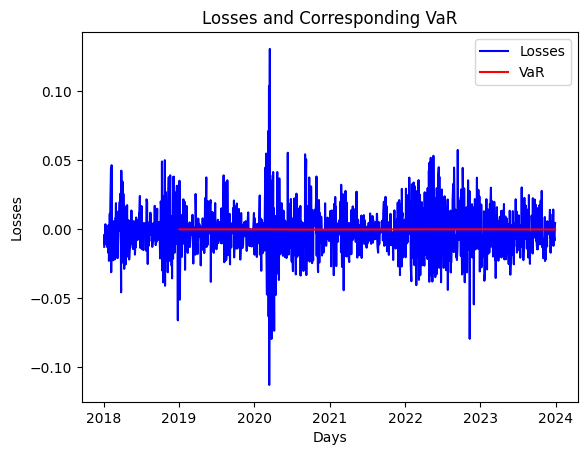

In [482]:
var_metrics['Normal VaR'] = stockdata['250D Mean Arithmetic Loss'].shift(1) * stats.norm.ppf(confidence_level) * stockdata['250D Volatility Arithmetic Loss']

losses = stockdata['Portfolio Arithmetic Loss']
var_estimates = var_metrics['Normal VaR']

# For consistency, all VaR metrics start from the 251st day
var_metrics['Normal VaR'][250] = np.nan

# Plot returns and corresponding VaR
plt.plot(stockdata.index, losses, label='Losses', color='blue')
plt.plot(stockdata.index, var_estimates, label='VaR', color='red')

plt.xlabel('Date')
plt.ylabel('Losses')
plt.title('Losses and Corresponding VaR')
plt.legend()
plt.grid(False)
plt.show()


### 2.b. Lognormal VaR
### VaR = 1-e^(Mean - Volatility * Z-Score)

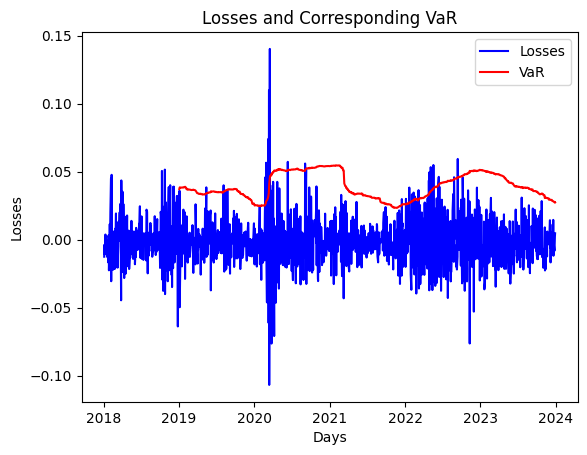

In [483]:
var_metrics['Lognormal VaR'] = 1 - np.exp(-stockdata['250D Mean Log Loss'].shift(1)  - stockdata['250D Volatility Log Loss'] * stats.norm.ppf(confidence_level))

losses = stockdata['Portfolio Log Loss']
var_estimates = var_metrics['Lognormal VaR']

# Plot returns and corresponding VaR
plt.plot(stockdata.index, losses, label='Losses', color='blue')
plt.plot(stockdata.index, var_estimates, label='VaR', color='red')

plt.xlabel('Date')
plt.ylabel('Losses')
plt.title('Losses and Corresponding VaR')
plt.legend()
plt.grid(False)
plt.show()


### 2.c. Generalised Extreme Value Theory VaR
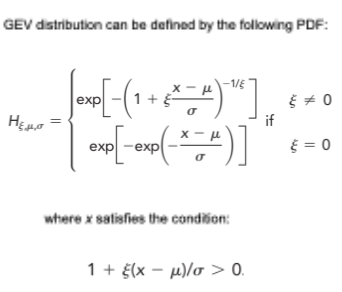


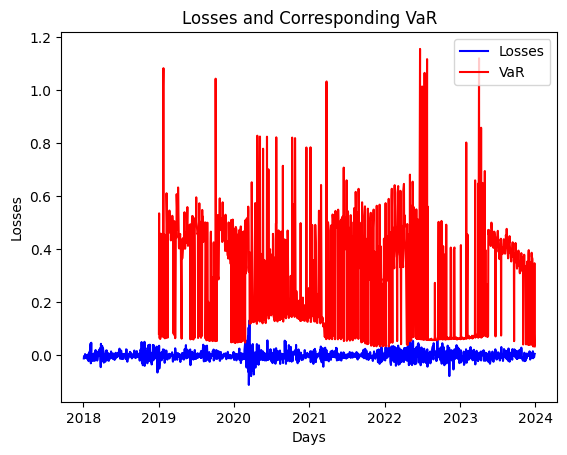

In [540]:
# Set block size
block_size = 10

lookback_period = 250

losses = stockdata['Portfolio Arithmetic Loss'].values

# Initialize array to store VaR estimates
var_estimates = np.zeros_like(stockdata['Portfolio Arithmetic Loss'])

# Iterate over each day to calculate VaR based on the block maxima over the previous 250 days
for i in range(len(losses)):
    if i < rolling_window:
        # Not enough data for the first 250 days, so set VaR to NaN
        var_estimates[i] = np.nan
    else:
        # Calculate VaR using block maxima method with a block size of 10 days
        block_losses = losses[i - lookback_period:i]
        block_maxima = np.max(block_losses.reshape(-1, block_size), axis=1)
        params = stats.genextreme.fit(block_maxima)
        var_estimates[i] = stats.genextreme.ppf(confidence_level, *params)
        
var_metrics['GEV VaR'] = var_estimates

# Plot returns and corresponding VaR
plt.plot(stockdata.index, losses, label='Losses', color='blue')
plt.plot(stockdata.index, var_estimates, label='VaR', color='red')

plt.xlabel('Date')
plt.ylabel('Losses')
plt.title('Losses and Corresponding VaR')
plt.legend()
plt.grid(False)
plt.show()


### 2.d. Peaks-Over-Threshold VaR

Threshold @ 95th Percentile: 0.04505765117091901


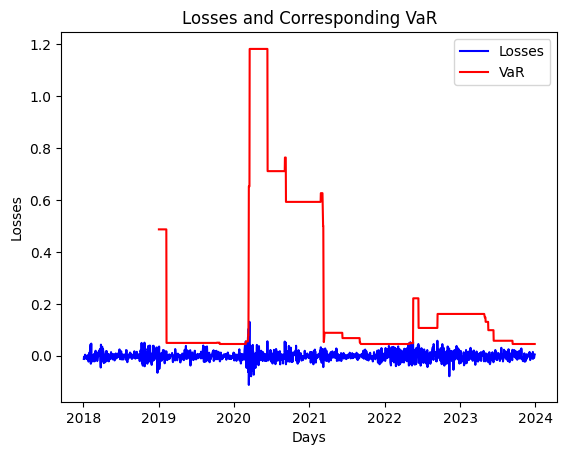

In [538]:
losses = stockdata['Portfolio Arithmetic Loss'].values

threshold = np.percentile(losses, 99)  # Set threshold at the 95th percentile of losses

# Identify exceedances (peaks over threshold)
exceedances = losses[losses > threshold]
exceedances

# Initialize array to store VaR estimates
var_estimates = np.zeros_like(losses)

# Iterate over each day to calculate VaR based on the exceedances over the previous 250 days
for i in range(len(losses)):
    if i < 250:
        # Not enough data for the first 250 days, so set VaR to NaN
        var_estimates[i] = np.nan
    else:
        # Calculate VaR based on exceedances over the previous 250 days
        exceedances = losses[i - 250:i][losses[i - 250:i] > threshold]
        if len(exceedances) > 0:
            params = stats.genpareto.fit(exceedances - threshold)
            var_estimates[i] = stats.genpareto.ppf(confidence_level, *params) + threshold
        else:
            # If no exceedances, set VaR to the threshold
            var_estimates[i] = threshold

print("Threshold @ 95th Percentile:", threshold)

var_metrics['POT VaR'] = var_estimates

# Plot returns and corresponding VaR
plt.plot(stockdata.index, losses, label='Losses', color='blue')
plt.plot(stockdata.index, var_estimates, label='VaR', color='red')

plt.xlabel('Date')
plt.ylabel('Losses')
plt.title('Losses and Corresponding VaR')
plt.legend()
plt.grid(False)
plt.show()


# 3. Non-parametric Approaches

### 3.a. Historical Simulation: Percentile

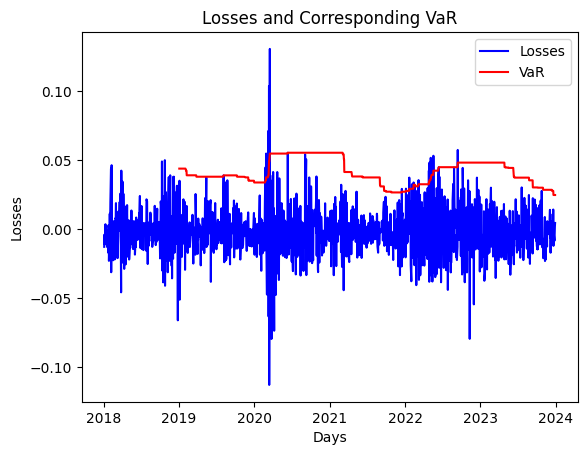

In [495]:
losses = stockdata['Portfolio Arithmetic Loss'].values

lookback_period = 250

# Iterate over each day to calculate VaR based on previous 250 days
for i in range(len(losses)):
    if i < 250:
        # Not enough data for the first 250 days, so set VaR to NaN
        var_estimates[i] = np.nan
    else:
        start_index = i - lookback_period + 1
        lookback_losses = np.sort(losses[start_index: i+1], kind='quicksort')[::-1]
        var_estimates[i] = lookback_losses[int(round((1 - float(confidence_level)) * lookback_period + 1 - 1))] # "(-1)" was added due to Python's zero-indexing convention

var_metrics['HS_Percentile VaR'] = var_estimates

# Plot returns and corresponding VaR
plt.plot(stockdata.index, losses, label='Losses', color='blue')
plt.plot(stockdata.index, var_estimates, label='VaR', color='red')

plt.xlabel('Date')
plt.ylabel('Losses')
plt.title('Losses and Corresponding VaR')
plt.legend()
plt.grid(False)
plt.show()

### 3.b. Historical Simulation: Age-Weighted

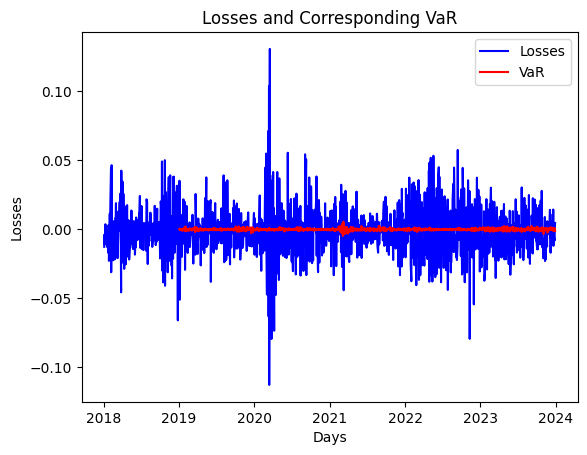

In [496]:
losses = stockdata['Portfolio Arithmetic Loss'].values
lookback_period = 250
# Create an age-weight np array 

decay_factor = 0.95 

# Total number of observations
n = 250
# Calculate weights for all i from 1 to 250
weight_age = np.array([np.power(decay_factor, i - 1) * (1 - decay_factor) / (1 - np.power(decay_factor, n)) for i in range(1, n + 1)])

# Iterate over each day to calculate VaR based on previous 250 days
for i in range(len(losses)):
    if i < 250:
        # Not enough data for the first 250 days, so set VaR to NaN
        var_estimates[i] = np.nan
    else:
        start_index = i - lookback_period + 1
        lookback_losses = losses[start_index: i+1] * weight_age
        var_estimates[i] = lookback_losses[int(round((1 - float(confidence_level)) * lookback_period + 1 - 1))] # "(-1)" was added due to Python's zero-indexing convention

var_metrics['HS_Age-Weight VaR'] = var_estimates

# Plot returns and corresponding VaR
plt.plot(stockdata.index, losses, label='Losses', color='blue')
plt.plot(stockdata.index, var_estimates, label='VaR', color='red')

plt.xlabel('Date')
plt.ylabel('Losses')
plt.title('Losses and Corresponding VaR')
plt.legend()
plt.grid(False)
plt.show()

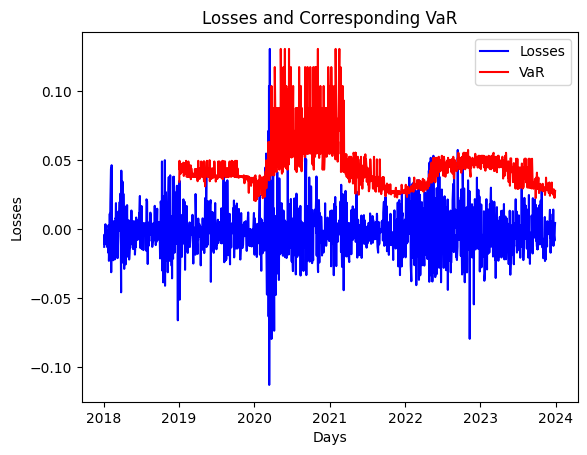

In [497]:
losses = stockdata['Portfolio Arithmetic Loss'].values
lookback_period = 250
bootstrap_samples = 1000

# Iterate over each day to calculate VaR based on previous 250 days
for i in range(len(losses)):
    if i < lookback_period:
        # Not enough data for the first 250 days, so set VaR to NaN
        var_estimates[i] = np.nan
    else:
        start_index = i - lookback_period + 1
        lookback_losses = losses[start_index: i+1]
        resampled_losses = np.random.choice(lookback_losses, size=len(lookback_losses), replace=True)
        bootstrap_var_samples = []
    # Calculate portfolio VaR for each bootstrap sample
        bootstrap_var_samples.append(np.percentile(resampled_losses, confidence_level * 100))
    # Calculate VaR estimate from bootstrap samples
        var_estimates[i] = np.percentile(bootstrap_var_samples, 100 * confidence_level)
        
var_metrics['Bootstrap VaR'] = var_estimates

# Plot returns and corresponding VaR
plt.plot(stockdata.index, losses, label='Losses', color='blue')
plt.plot(stockdata.index, var_estimates, label='VaR', color='red')

plt.xlabel('Date')
plt.ylabel('Losses')
plt.title('Losses and Corresponding VaR')
plt.legend()
plt.grid(False)
plt.show()

### 3.d Monte Carlo Simulation

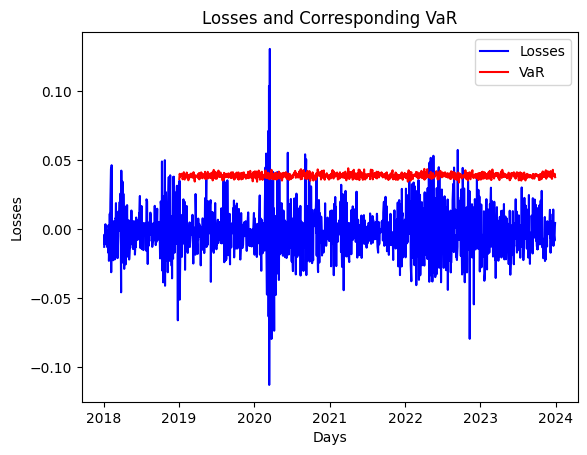

In [542]:
losses = stockdata['Portfolio Arithmetic Loss'].values
lookback_period = 250

# Iterate over each day to calculate VaR based on previous 250 days
for i in range(len(losses)):
    if i < lookback_period:
        # Not enough data for the first 250 days, so set VaR to NaN
        var_estimates[i] = np.nan
    else:
        start_index = i - lookback_period + 1
        lookback_losses = losses[start_index: i+1]
        simulated_losses = np.random.normal(loc=np.mean(losses), scale=np.std(losses), size=len(losses))
        montecarlo_var_samples = []
    # Calculate portfolio VaR for each Monte Carlo sample
        montecarlo_var_samples.append(np.percentile(simulated_losses, confidence_level * 100))
    # Calculate VaR estimate from bootstrap samples
        var_estimates[i] = np.percentile(montecarlo_var_samples, 100 * confidence_level)
        
var_metrics['Monte Carlo VaR'] = var_estimates

# Plot returns and corresponding VaR
plt.plot(stockdata.index, losses, label='Losses', color='blue')
plt.plot(stockdata.index, var_estimates, label='VaR', color='red')

plt.xlabel('Date')
plt.ylabel('Losses')
plt.title('Losses and Corresponding VaR')
plt.legend()
plt.grid(False)
plt.show()

In [499]:
var_metrics['Portfolio Arithmetic Loss'] = stockdata['Portfolio Arithmetic Loss']
var_metrics['Portfolio Log Loss'] = stockdata['Portfolio Log Loss']

## 4. Model Performance Metrics:

## Exceedances Ratio

In [541]:
performance_var = pd.DataFrame()

for method in [col for col in var_metrics.columns if 'VaR' in col]:
    if method ==  'Lognormal VaR':
        # Calculate exceedances (observations that exceed VaR)
        exceedances = var_metrics['Portfolio Log Loss'].values[var_metrics['Portfolio Log Loss'].values > var_metrics[method].values]

        exceedance_ratio = len(exceedances) / len(stockdata['Portfolio Log Loss'].values)

        temp_df = pd.DataFrame({
        'Method': method,
        'Exceedances': [len(exceedances)],
        'Exceedance Ratio': exceedance_ratio})
        performance_var = pd.concat([performance_var, temp_df])
    else:
        # Calculate exceedances (observations that exceed VaR)
        exceedances = var_metrics['Portfolio Arithmetic Loss'].values[var_metrics['Portfolio Arithmetic Loss'].values > var_metrics[method].values]

        exceedance_ratio = len(exceedances) / len(stockdata['Portfolio Arithmetic Loss'].values)

        temp_df = pd.DataFrame({
        'Method': method,
        'Exceedances': [len(exceedances)],
        'Exceedance Ratio': exceedance_ratio})
        performance_var = pd.concat([performance_var, temp_df])
        
performance_var.set_index('Method', inplace=True)
print(f'Acceptable Exceedances: {round(len(stockdata)* (1-confidence_level))}')


performance_var['Acceptable No. of Exceed.'] = performance_var['Exceedances'].apply(lambda x: 'Not Acceptable' if x > round(len(stockdata)* (1-confidence_level)) else 'Acceptable')
print(performance_var)

Acceptable Exceedances: 15
                   Exceedances  Exceedance Ratio Acceptable No. of Exceed.
Method                                                                    
Normal VaR                 559          0.370690            Not Acceptable
Lognormal VaR               30          0.019894            Not Acceptable
GEV VaR                      1          0.000663                Acceptable
POT VaR                      5          0.003316                Acceptable
HS_Percentile VaR           17          0.011273            Not Acceptable
HS_Age-Weight VaR          561          0.372016            Not Acceptable
Bootstrap VaR               18          0.011936            Not Acceptable
Monte Carlo VaR             22          0.014589            Not Acceptable
